In [136]:
library(simplexreg)
library(LaplacesDemon)
library(Rfast2)
library(Rfast)
library(emg)
library(glogis)
library(sn)
library(statmod)
library(EnvStats)
library(VGAM)

## Estimation of Laplace Distribution
laplace_mle = function(F_2_neg) {
    mu = median(F_2_neg)
    si = mean(abs(F_2_neg - mu))
    f2 = dlogis(F_2_neg, 0, 1)
    f1 = dlaplace(F_2_neg, mu, si)
    loglik = sum(log(f1 / f2))
    
    result_list = list(mu = mu, si = si, loglik = loglik)
    return(result_list)
}

## Estimation of Normal Distribution
normal_mle = function(F_2_neg) {
    mu = mean(F_2_neg)
    si = sqrt(sum((F_2_neg - mu)^2) / (length(F_2_neg) - 1))
    f2 = dlogis(F_2_neg, 0, 1)
    f1 = dnorm(F_2_neg, mu, si)
    loglik = sum(log(f1 / f2))
    
    result_list = list(mu = mu, si = si, loglik = loglik)
    return(result_list)
}

## Estimation of Cauchy Distribution
cauchy_mle = function(F_2_neg) {
    fit = cauchy.mle(F_2_neg)
    mu = fit$param[1]
    si = fit$param[2]
    f2 = dlogis(F_2_neg, 0, 1)
    f1 = dcauchy(F_2_neg, mu, si)
    loglik = sum(log(f1 / f2))
    
    result_list = list(mu = mu, si = si, loglik = loglik)
    return(result_list)
}

## Estimation of Beta Distribution
beta_mle = function(x) {
    x = as.numeric(x)
    fit = ebeta(x, method = "mle")
    al = fit$param[1]
    be = fit$param[2]
    loglik = sum(log(dbeta(x, al, be)))
    
    result_list = list(al = al, be = be, loglik = loglik)
    return(result_list)
}

## Estimation of Simplex Distribution
simplex_mle = function(x) {
    x = as.numeric(x)
    fit = simplex.mle(x)
    al = fit$param[1]
    be = fit$param[2]
    loglik = fit$loglik
    
    result_list = list(al = al, be = be, loglik = loglik)
    return(result_list)
}

## Estimation of Gumbel Distribution
gumbel_mle = function(F_2_neg) {
    fit = gumbel.mle(F_2_neg)
    mu = fit$param[1]
    si = fit$param[2]
    f2 = dlogis(F_2_neg, 0, 1)
    f1 = dgumbel(F_2_neg, mu, si)
    loglik = sum(log(f1 / f2))
    
    result_list = list(mu = mu, si = si, loglik = loglik)
    return(result_list)
}

## Estimation of Logistic Distribution
logistic_mle = function(F_2_neg) {
    fit = logistic.mle(F_2_neg)
    mu = fit$param[1]
    si = fit$param[2]
    f2 = dlogis(F_2_neg, 0, 1)
    f1 = dlogis(F_2_neg, mu, si)
    loglik = sum(log(f1 / f2))
    
    result_list = list(mu = mu, si = si, loglik = loglik)
    return(result_list)
}

## Estimation of T Distribution
t_mle = function(F_2_neg) {
    esp = 1; mu = 0; si = 1; nu = 1; k = 0; loglikelihood = c()
    n = length(F_2_neg)
    while (esp > 1e-10 & k < 10000) {
        k = k + 1
        x.tra = exp((F_2_neg - mu) / si)
        mu.new = 0.5 * mean((F_2_neg - mu) / (1 + (F_2_neg - mu)^2 / si^2 / nu)) + mu
        mu = mu.new
        
        x.tra = exp((F_2_neg - mu) / si)
        A = nu * si^2 * 2 / (nu + 1)
        B = mean(-2 * (F_2_neg - mu)^2 / (1 + (F_2_neg - mu)^2 / si^2 / nu) + 4 * (F_2_neg - mu)^2)
        C = mean(-4 * (F_2_neg - mu)^2)
        si.new = (-B + sqrt(B^2 - 4 * C * A)) / (2 * A)
        si = si.new * si
        
        z = (F_2_neg - mu)^2 / si^2
        taui = z / (1 + z / nu)
        g = n / 2 * (digamma((nu + 1) / 2) - digamma(nu / 2) - 1 / nu) - 0.5 * sum(log(1 + z / nu)) + (nu + 1) / (2 * nu^2) * sum(taui)
        nu.new = n * nu / (n - nu * g)
        nu = nu.new
        
        f2 = dlogis(F_2_neg, 0, 1)
        f1 = dt((F_2_neg - mu) / si, nu) / si
        loglikelihood[k] = sum(log(f1 / f2))
        if (k > 1) {
            esp = abs(loglikelihood[k] - loglikelihood[k - 1]) / abs(loglikelihood[k])
        }
    }
    
    loglik = loglikelihood[k]
    result_list = list(mu = mu, si = si, nu = nu, loglik = loglik)
    return(result_list)
}

## Estimation of Skew-Normal Distribution
skewnormal_mle = function(F_2_neg) {
    fit = selm(F_2_neg ~ 1, family = "SN")
    mu = coef(fit)[1]
    si = coef(fit)[2]
    la = coef(fit)[3]
    f2 = dlogis(F_2_neg, 0, 1)
    f1 = dsn(F_2_neg, mu, si, la)
    loglik = sum(log(f1 / f2))
    
    result_list = list(mu = mu, si = si, la = la, loglik = loglik)
    return(result_list)
}

## Estimation of Generalized Logistic Distribution (GLI)
glogistic_mle = function(F_2_neg) {
    fit = glogisfit(F_2_neg)
    mu = fit$parameters[1]
    si = fit$parameters[2]
    la = fit$parameters[3]
    f2 = dlogis(F_2_neg, 0, 1)
    f1 = dglogis(F_2_neg, mu, si, la)
    loglik = sum(log(f1 / f2))
    
    result_list = list(mu = mu, si = si, la = la, loglik = loglik)
    return(result_list)
}

## Estimation of Inverse Gamma Distribution
invgamma_mle = function(F_2_neg) {
    esp = 1; al = 1; be = 1; k = 0; loglikelihood = c()
    while (esp > 1e-10 & k < 1000) {
        k = k + 1
        be.new = al / mean(1 / F_2_neg)
        be = be.new
        g.0 = log(be) - mean(log(F_2_neg)) - digamma(al)
        A = -pi^2 / 6
        B = g.0 - (1 / al - pi^2 / 6 * al)
        C = 1
        al.new = (-B - sqrt(B^2 - 4 * C * A)) / (2 * A)
        al = al.new
        
        f1 = dinvgamma(F_2_neg, al, be)
        f2 = 1 / (1 + F_2_neg)^2
        loglikelihood[k] = sum(log(f1 / f2))
        
        if (k > 1) {
            esp = abs(loglikelihood[k] - loglikelihood[k - 1]) / abs(loglikelihood[k])
        }
    }
    loglik = loglikelihood[k]
    
    result_list = list(al = al, be = be, loglik = loglik)
    return(result_list)
}


## Estimation of Gamma Distribution
gamma_mle = function(F_2_neg){
    fit = gammamle(F_2_neg)
    al  = fit$param[1]
    be  = fit$param[2]
    f1 = dgamma(F_2_neg, al, be)
    f2 = 1/(1+F_2_neg)^2
    loglik = sum(log(f1/f2))
    
    result_list = list(al = al, be = be, loglik = loglik)
    return(result_list)
}

## Estimation of Lognormal Distribution
lognormal_mle = function(F_2_neg){
    fit = lognorm.mle(F_2_neg)
    mu  = fit$param[1]
    si  = sqrt(fit$param[2]) # 第二个输出是 variance，要开根号加入dlnorm的第三个参数
    f1 = dlnorm(F_2_neg, mu, si)
    f2 = 1/(1+F_2_neg)^2
    loglik = sum(log(f1/f2))
    
    result_list = list(mu = mu, si = si, loglik = loglik)
    return(result_list)
}

## Estimation of Weibull Distribution
weibull_mle = function(F_2_neg){
    esp = 1; al=1e-8; be = 1; k =0;loglikelihood = 0 ## al 是 shape，be 是 scale
    while(esp>1e-10 & k<1000){
        k = k+1
        be.new = (mean(F_2_neg^al))^(1/al)
        be = be.new

        z = log(F_2_neg/be)
        n.0 = sum(F_2_neg <= be) - sum(F_2_neg <=0)
        g.0 = n/al + sum(z - z*exp(z*al))
        a.9 = n+2*n.0/3
        z.I1 = z[F_2_neg/be>1]
        z.I1 = z.I1*al - 1
        z.I1[z.I1<0] = 0
        a.10 = sum(4*exp(2*z.I1))
        A = (a.10 - a.9)/al + g.0
        B = -(2*al*g.0 - 3*a.9+a.10)
        C = -2*a.9
        al.new = (-B+sqrt(B^2-4*C*A))/(2*A)
        al = al.new

        f1 = dweibull(F_2_neg, al, be)
        f1[f1<=0] = 1e-10
        f2 = 1/(1+F_2_neg)^2
        loglikelihood[k] = sum(log(f1/f2))

        if(k>1){
            esp = abs(loglikelihood[k]-loglikelihood[k-1])/abs(loglikelihood[k])
        }
    }
    loglik = loglikelihood[k]
    
    result_list = list(al = al, be = be, loglik = loglik)
    return(result_list)
}

## Estimation of Inv-G Distribution
invgauss_mle = function(F_2_neg){
    fit = invgauss.mle(F_2_neg)
    mu  = fit$param[1]
    si  = fit$param[2]
    f1 = dinv.gaussian(F_2_neg, mu, si)
    f2 = 1/(1+F_2_neg)^2
    loglik = sum(log(f1/f2))
    
    result_list = list(mu = mu, si = si, loglik = loglik)
    return(result_list)
}

In [124]:
plot_fitness = function(mu,si,nu=1,dfun){
    xx = seq(0,1,0.001)
    if(dfun == "Log-Slog"){
          F_2_neg1 = -log(1/xx-1)
          yy = dlogis(F_2_neg1, mu, si)/dlogis(F_2_neg1, 0, 1)
    }else if(dfun == "Lap-Slog"){
          F_2_neg1 = -log(1/xx-1)
          yy = dlaplace(F_2_neg1, mu, si)/dlogis(F_2_neg1, 0, 1)
    }else if(dfun == "N-Slog"){
          F_2_neg1 = -log(1/xx-1)
          yy = dnorm(F_2_neg1, mu, si)/dlogis(F_2_neg1, 0, 1)
    }else if(dfun == "Gmax-Slog"){
          F_2_neg1 = -log(1/xx-1)
          yy = dgumbel(F_2_neg1, mu, si)/dlogis(F_2_neg1, 0, 1)
    }else if(dfun == "Cauc-Slog"){
          F_2_neg1 = -log(1/xx-1)
          yy = dcauchy(F_2_neg1, mu, si)/dlogis(F_2_neg1, 0, 1)
    }else if(dfun == "T-Slog"){
          F_2_neg1 = -log(1/xx-1)
          yy = dt((F_2_neg1-mu)/si, nu)/si/dlogis(F_2_neg1, 0, 1)
    }else if(dfun == "GLI-Slog"){
          F_2_neg1 = -log(1/xx-1)
          yy = dglogis(F_2_neg1, mu, si, nu)/dlogis(F_2_neg1, 0, 1)
    }else if(dfun == "SN-Slog"){
          F_2_neg1 = -log(1/xx-1)
          yy = dsn(F_2_neg1, mu, si, nu)/dlogis(F_2_neg1, 0, 1)
    }else if(dfun == "IGa-SIB"){
          F_2_neg1 = xx/(1-xx)
          yy = dinvgamma(F_2_neg1, mu,si)*(1+F_2_neg1)^2
    }else if(dfun == "Gam-SIB"){
          F_2_neg1 = xx/(1-xx)
          yy = dgamma(F_2_neg1, mu,si)*(1+F_2_neg1)^2
    }else if(dfun == "LogN-SIB"){
          F_2_neg1 = xx/(1-xx)
          yy = dlnorm(F_2_neg1, mu,si)*(1+F_2_neg1)^2
    }else if(dfun == "Weib-SIB"){
          F_2_neg1 = xx/(1-xx)
          yy = dweibull(F_2_neg1, mu,si)*(1+F_2_neg1)^2
    }else if(dfun == "IG-SIB"){
          F_2_neg1 = xx/(1-xx)
          yy = dinv.gaussian(F_2_neg1, mu,si)*(1+F_2_neg1)^2
    }else if(dfun == "IBeta-SIB"){
          F_2_neg1 = xx
          yy = dbeta(F_2_neg1, mu,si)
    }else if(dfun == "Simplex"){
          F_2_neg1 = xx
          yy = dsimplex(F_2_neg1, mu,si)
    }

    hist(x,xlim = c(min(x), max(x)), breaks = breaks, main = dfun)
    lines(xx,yy*n/width,col='red')
}

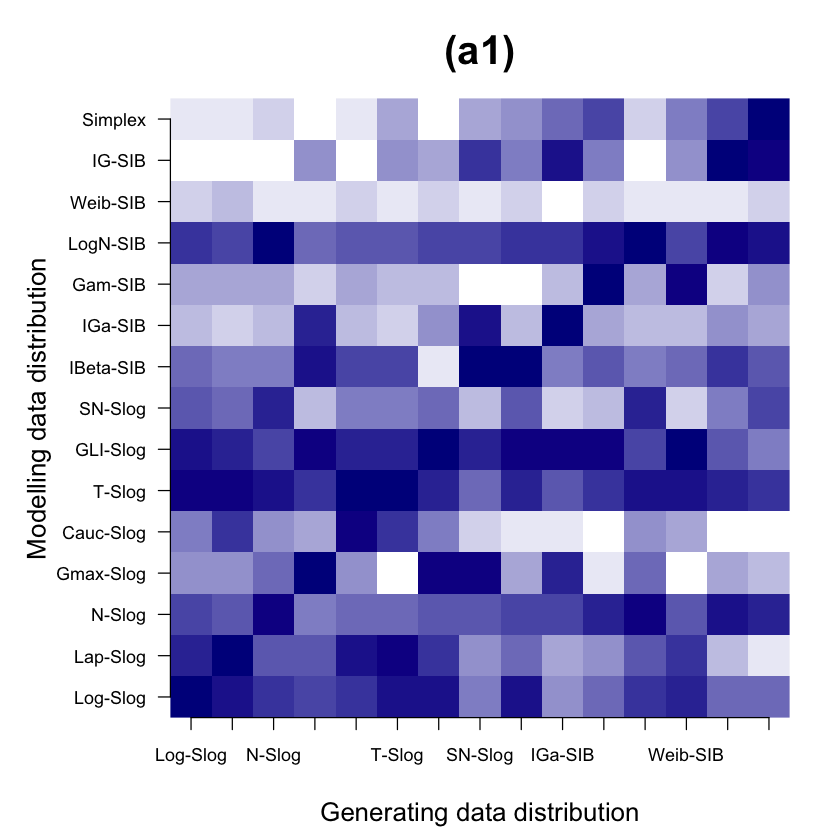

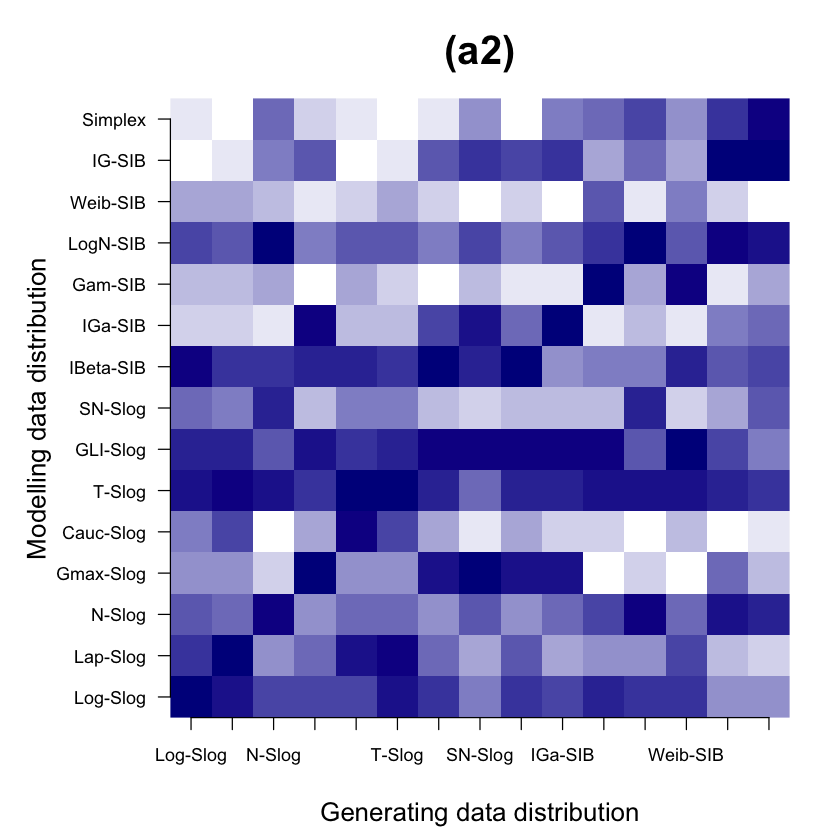

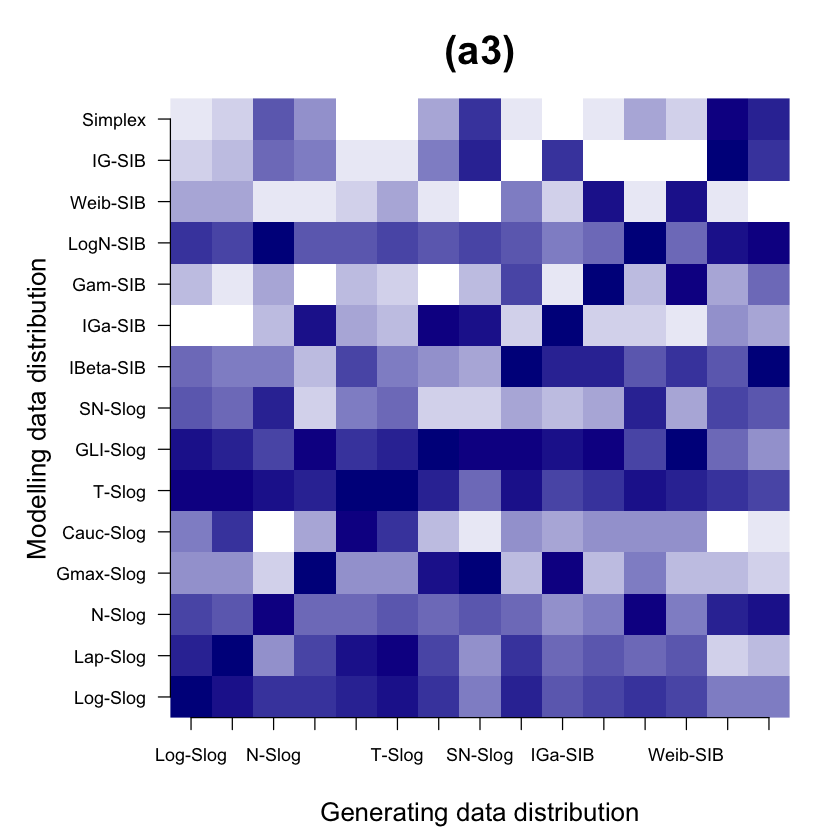

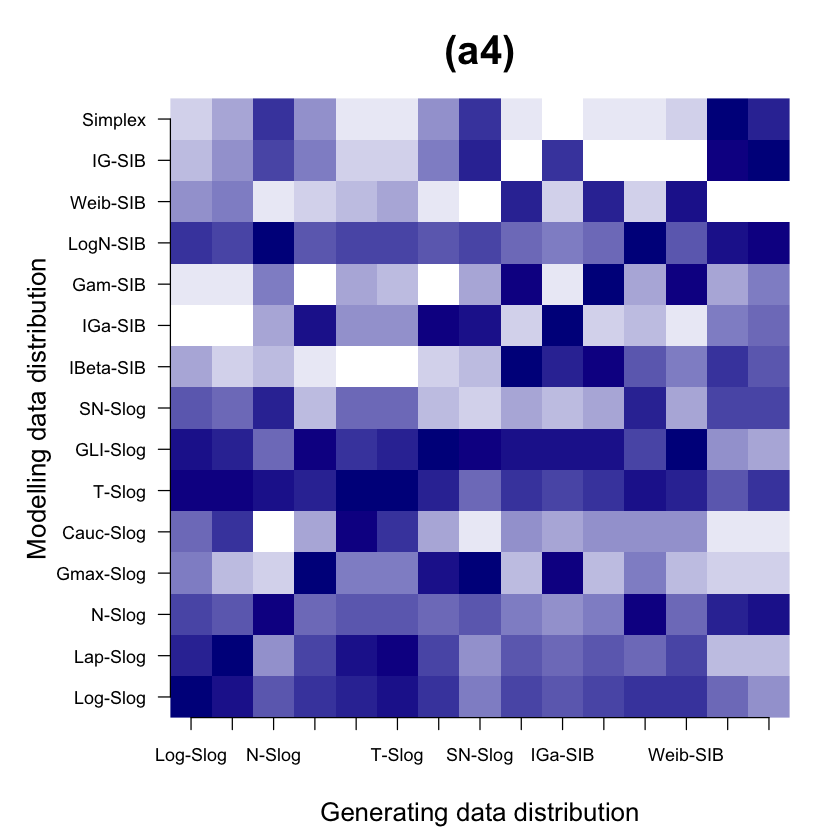

In [88]:
dis_r_names = c("rlogis","rlaplace","rnorm","rgumbel","rcauchy",
                "rt","rglogis","rsn","rbeta","rinvgamma",
                "rgamma","rlnorm","rweibull","rinvgaussian","rsimplex")

dis_names = c("Log-Slog", "Lap-Slog", "N-Slog", "Gmax-Slog", "Cauc-Slog",
              "T-Slog", "GLI-Slog", "SN-Slog", "IBeta-SIB", "IGa-SIB",
              "Gam-SIB", "LogN-SIB", "Weib-SIB", "IG-SIB", "Simplex")

x_norm = matrix(0,15,15)

for(kinds in c(1:4)){
    for(i in c(1:15)){
        set.seed(100)

        n = 1000
        dis1 = dis_r_names[i]

        parameters = matrix(c(    3,   2,  4,   3,   2,  0.7,
                                  0,   1,  4,   2, 0.8,  0.5,
                                 -3, 0.8,  4, 0.8,   2,  0.3,
                                 -6, 0.7,  4, 0.8,   5,  0.2),
                                  4,   6,     byrow = T)
#         kinds = 3
        mu_gen = parameters[kinds,1]
        si_gen = parameters[kinds,2]
        nu_gen = parameters[kinds,3]
        al_gen = parameters[kinds,4]
        be_gen = parameters[kinds,5]
        mu_gen1 = parameters[kinds,6]

        if(i<=5){
            F.generate = do.call(dis1, list(n, mu_gen, si_gen))
            x = plogis(F.generate, 0, 1)
        }else if(i==6){
            F.generate = (rt(n, nu_gen)+mu_gen)/si_gen
            x = plogis(F.generate, 0, 1)
        }else if(i<=8 & i>=7){
            F.generate = do.call(dis1, list(n, mu_gen, si_gen, nu_gen))
            x = plogis(F.generate, 0, 1)
        }else if(i==9){
            x = do.call(dis1, list(n, al_gen, be_gen))
        }else if(i<=14 & i>=10){
            F.generate = do.call(dis1, list(n, al_gen, be_gen))
            x = F.generate/(1+F.generate)
        }else if(i==15){
            x = rsimplex(n, mu_gen1, si_gen)
        }


        breaks = c(0:14)/14
        width = 10

        n = length(x)
        x[x<1e-8] = 1e-8
        x[x>(1-1e-8)] = 1-1e-8
        F_2_neg = -log(1/x-1)
        par(mfrow=c(2,3))



        ## estimation of logistic distribution
        fit = logistic_mle(F_2_neg)
        log_logistic = fit$loglik

        ## estimation of Laplace distribution
        fit = laplace_mle(F_2_neg)
        log_laplace = fit$loglik


        ## estimation of normal distribution
        fit = normal_mle(F_2_neg)
        log_normal = fit$loglik

        ## estimation of gumbel distribution
        fit = gumbel_mle(F_2_neg)
        log_gumbel = fit$loglik

        ## estimation of cauchy distribution
        fit = cauchy_mle(F_2_neg)
        log_cauchy = fit$loglik

        ## estimation of beta distribution
        fit = beta_mle(x)
        log_beta = fit$loglik

        ## estimation of simplex distribution
        fit = simplex_mle(x)
        log_simplex = fit$loglik

        ## estimation of t distribution
        fit = t_mle(F_2_neg)
        log_t = fit$loglik

        ## estimation of SN distribution
        fit = skewnormal_mle(F_2_neg)
        log_SN = fit$loglik

        ## estimation of GLI distribution
        fit = glogistic_mle(F_2_neg)
        log_GLI = fit$loglik


        results_real_line = c(log_logistic,log_laplace,log_normal,log_gumbel,log_cauchy,log_t,log_GLI,log_SN,log_beta)
        names(results_real_line) = c("log_logistic","log_laplace","log_normal","log_gumbel","log_cauchy","log_t","log_GLI","log_SN","log_beta")

        ########### positive line
        F_2_neg = x/(1-x)
        par(mfrow=c(2,3))




        ## estimation of IGamma distribution
        fit = invgamma_mle(F_2_neg)
        log_invgamma = fit$loglik

        ## estimation of gamma distribution
        fit = gamma_mle(F_2_neg)
        log_gamma = fit$loglik

        ## estimation of lognormal distribution
        fit = lognormal_mle(F_2_neg)
        log_lnorm = fit$loglik

        ## estimation of weibull distribution
        fit = weibull_mle(F_2_neg)
        log_weibull = fit$loglik

        ## estimation of Inv-G distribution
        fit = invgauss_mle(F_2_neg)
        log_invgauss = fit$loglik

        results_positive_line = c(log_invgamma,log_gamma,log_lnorm,log_weibull,log_invgauss,log_simplex)
        names(results_positive_line) = c("log_invgamma","log_gamma","log_lnorm","log_weibull","log_invgauss","log_simplex")

        res_all = c(results_real_line,results_positive_line)
        res_all = c(-2*results_real_line+2*c(2,2,2,2,2,3,3,3,2),-2*results_positive_line+2*c(2,2,2,2,2,2))

        # 假设 x 是原始数据
        x_norm[i,] <- res_all
    }
    

    x_norm_colsum = colMeans(x_norm)
    names(x_norm_colsum) = dis_names
    t(x_norm_colsum)

    # 计算每行的排名
    x_rank <- apply(x_norm, 1, function(x) rank(-x))
    x_rank = t(x_rank)
    x_rank_colsum = colMeans(x_rank)
    names(x_rank_colsum) = dis_names
    t(x_rank_colsum)

    # 创建一个新的绘图设备,并设置合适的宽高比
    par(mfrow=c(1,1))
    par(mar = c(5.1, 7.1, 4.1, 2.1)) # 增加左边距
    par(mgp = c(3.5, 1, 0)) # 保持 x 轴标签位置不变
    plot.window(xlim = c(0, 14), ylim = c(0, 14))
    # 绘制heatmap
    image(x_rank,
          axes = FALSE,
          col = colorRampPalette(c("white", "darkblue"))(15),
          xlab = "Generating data distribution",
          ylab = "",  # 先不设置 ylab
          cex.lab = 1.3, cex.main = 2,
          main = paste0("(a",kinds,")")
    )
    # 添加自定义的 ylab，使用 mtext 进行位置调整
    mtext("Modelling data distribution", side = 2, line = 5, cex = 1.3)
    # 添加 x 轴标签
    axis(1, at = 0:14*0.07142857, labels = dis_names[1:15], cex.axis = 0.9)
    # 添加 y 轴标签
    axis(2, at = 0:14*0.07142857, labels = dis_names[1:15], las = 2, cex.axis = 0.9)
}


In [133]:
library(LaplacesDemon)
library(Rfast)
library(emg)
library(MCMCpack)
library(VGAM)

dir <- "/Users/caleblee/Desktop/skill summit time/2022年论文 正在写/0-1 distribution/"
dir1 <- "/Users/caleblee/Desktop/skill summit time/2022年论文 正在写/0-1 distribution/R program/"

# input_file <- paste0(dir1, "hospital_count1988.csv")
input_file2 <- paste0(dir1, "hospital_count1990.csv")
# input_file <- paste0(dir1, "Diab_pyth_data.csv")

data1 = read.csv(input_file, header=T)
# data1 = read.csv(input_file2, header=T)
data2 = read.csv(input_file2, header=T)
data1 = rbind(data1,data2)


x = data1$y/data1$day
# x = data1$percentage.of.occuring.diabetes/100

n = length(x)
F_2_neg = -log(1/x-1)

width = 10
breaks = c(0:width)/width


# 打开一个 PDF 设备
# output_file <- paste0(dir, "diab1.pdf")
# output_file <- paste0(dir, "data1_half1.pdf")
# output_file <- paste0(dir, "data2_half1.pdf")
output_file <- paste0(dir, "data_full1.pdf")
pdf(output_file, width = 10, height = 7)

par(mfrow=c(2,4))

## estimation of logistic distribution
fit = logistic_mle(F_2_neg)
log_logistic = fit$loglik
plot_fitness(fit$mu,fit$si,dfun="Log-Slog")

## estimation of Laplace distribution
fit = laplace_mle(F_2_neg)
log_laplace = fit$loglik
plot_fitness(fit$mu,fit$si,dfun="Lap-Slog")


## estimation of normal distribution
fit = normal_mle(F_2_neg)
log_normal = fit$loglik
plot_fitness(fit$mu,fit$si,dfun="N-Slog")

## estimation of gumbel distribution
fit = gumbel_mle(F_2_neg)
log_gumbel = fit$loglik
plot_fitness(fit$mu,fit$si,dfun="Gmax-Slog")

## estimation of cauchy distribution
fit = cauchy_mle(F_2_neg)
log_cauchy = fit$loglik
plot_fitness(fit$mu,fit$si,dfun="Cauc-Slog")

## estimation of t distribution
fit = t_mle(F_2_neg)
log_t = fit$loglik
plot_fitness(fit$mu,fit$si,fit$nu,dfun="T-Slog")

## estimation of GLI distribution
fit = glogistic_mle(F_2_neg)
log_GLI = fit$loglik
plot_fitness(fit$mu,fit$si,fit$la,dfun="GLI-Slog")

## estimation of SN distribution
fit = skewnormal_mle(F_2_neg)
log_SN = fit$loglik
plot_fitness(fit$mu,fit$si,fit$la,dfun="SN-Slog")

dev.off()


# 打开一个 PDF 设备
# output_file <- paste0(dir, "diab2.pdf")
# output_file <- paste0(dir, "data1_half2.pdf")
# output_file <- paste0(dir, "data2_half2.pdf")
output_file <- paste0(dir, "data_full2.pdf")
pdf(output_file, width = 10, height = 7)

par(mfrow=c(2,4))

## estimation of beta distribution
fit = beta_mle(x)
log_beta = fit$loglik
plot_fitness(fit$al,fit$be,dfun="IBeta-SIB")

results_real_line = c(log_logistic,log_laplace,log_normal,log_gumbel,log_cauchy,log_t,log_GLI,log_SN,log_beta)
names(results_real_line) = c("log_logistic","log_laplace","log_normal","log_gumbel","log_cauchy","log_t","log_GLI","log_SN","log_beta")

########### positive line
F_2_neg = x/(1-x)
# par(mfrow=c(2,4))

## estimation of IGamma distribution
fit = invgamma_mle(F_2_neg)
log_invgamma = fit$loglik
plot_fitness(fit$al,fit$be,dfun="IGa-SIB")

## estimation of gamma distribution
fit = gamma_mle(F_2_neg)
log_gamma = fit$loglik
plot_fitness(fit$al,fit$be,dfun="Gam-SIB")

## estimation of lognormal distribution
fit = lognormal_mle(F_2_neg)
log_lnorm = fit$loglik
plot_fitness(fit$mu,fit$si,dfun="LogN-SIB")

## estimation of weibull distribution
fit = weibull_mle(F_2_neg)
log_weibull = fit$loglik
plot_fitness(fit$al,fit$be,dfun="Weib-SIB")

## estimation of Inv-G distribution
fit = invgauss_mle(F_2_neg)
log_invgauss = fit$loglik
plot_fitness(fit$mu,fit$si,dfun="IG-SIB")

## estimation of simplex distribution
fit = simplex_mle(x)
log_simplex = fit$loglik
plot_fitness(fit$al,fit$be,dfun="Simplex")

dev.off()

results_positive_line = c(log_invgamma,log_gamma,log_lnorm,log_weibull,log_invgauss,log_simplex)
names(results_positive_line) = c("log_invgamma","log_gamma","log_lnorm","log_weibull","log_invgauss","log_simplex")

res_all = c(results_real_line,results_positive_line)
res_all = c(-2*results_real_line+2*c(2,2,2,2,2,3,3,3,2),-2*results_positive_line+2*c(2,2,2,2,2,2))



# 假设 x 是原始数据
t(res_all)


# result.realdata = matrix(0,1,12)
# kk = 2
# result.realdata = rbind(result.realdata,res_all)
# write.csv(res_all,"/Users/caleblee/Desktop/0-1 distribution/result_realcase2.csv")


pdf 
  2

pdf 
  2

log_logistic,log_laplace,log_normal,log_gumbel,log_cauchy,log_t,log_GLI,log_SN,log_beta,log_invgamma,log_gamma,log_lnorm,log_weibull,log_invgauss,log_simplex
-155.912,-112.8646,-167.0589,-135.9206,28.79969,-164.9684,-164.5387,-128.822,-152.3246,-132.3127,-14.25234,-167.0598,-28.6713,-171.5312,-155.694
